<a href="https://colab.research.google.com/github/Usamaahmad06/Avalanche-an-end-to-end-library-for-continual-learning/blob/main/All_CL_Strategies_on_Datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install avalanche-lib --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 971.9/971.9 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.4/532.4 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0

In [3]:
import torch
import torchvision
import matplotlib.pyplot as plt

from avalanche.benchmarks.classic import SplitMNIST, SplitCIFAR100
from avalanche.benchmarks.utils import as_classification_dataset
from avalanche.evaluation.metrics import accuracy_metrics
from avalanche.logging import InteractiveLogger, TextLogger
from avalanche.training.plugins import EvaluationPlugin
from avalanche.training.supervised import Naive

# Define model, loss function, and optimizer
def get_model(output_size):
    return torch.nn.Sequential(
        torch.nn.Flatten(),
        torch.nn.Linear(28 * 28, 512),
        torch.nn.ReLU(),
        torch.nn.Linear(512, output_size)
    )

model_mnist = get_model(10)
model_fashion_mnist = get_model(10)

model_cifar100 = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(3 * 32 * 32, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 100)
)

criterion = torch.nn.CrossEntropyLoss()
optimizer_mnist = torch.optim.SGD(model_mnist.parameters(), lr=0.01)
optimizer_fashion_mnist = torch.optim.SGD(model_fashion_mnist.parameters(), lr=0.01)
optimizer_cifar100 = torch.optim.SGD(model_cifar100.parameters(), lr=0.01)

# Evaluation plugin
interactive_logger = InteractiveLogger()
text_logger = TextLogger(open('log.txt', 'w'))
eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    loggers=[interactive_logger, text_logger]
)

# Load the datasets using Avalanche
scenario_mnist = SplitMNIST(n_experiences=5, seed=1)
scenario_cifar100 = SplitCIFAR100(n_experiences=5, seed=1)

# Load FashionMNIST using torchvision and create a custom benchmark
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))
])

fashion_mnist_train = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
fashion_mnist_test = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Creating classification datasets
train_fashion_mnist = as_classification_dataset(fashion_mnist_train, transform_groups={'train': transform, 'eval': transform})
test_fashion_mnist = as_classification_dataset(fashion_mnist_test, transform_groups={'train': transform, 'eval': transform})

from avalanche.benchmarks import nc_benchmark

scenario_fashion_mnist = nc_benchmark(
    train_dataset=train_fashion_mnist,
    test_dataset=test_fashion_mnist,
    n_experiences=5,
    task_labels=False,
    shuffle=True,
    seed=1
)

# Naive strategies for each dataset
naive_mnist = Naive(model_mnist, optimizer_mnist, criterion, train_mb_size=32, train_epochs=2, eval_mb_size=32, evaluator=eval_plugin)
naive_fashion_mnist = Naive(model_fashion_mnist, optimizer_fashion_mnist, criterion, train_mb_size=32, train_epochs=2, eval_mb_size=32, evaluator=eval_plugin)
naive_cifar100 = Naive(model_cifar100, optimizer_cifar100, criterion, train_mb_size=32, train_epochs=2, eval_mb_size=32, evaluator=eval_plugin)

# Function to run the strategy on a given scenario
def run_naive_strategy(scenario, strategy):
    accuracies = []
    for experience in scenario.train_stream:
        strategy.train(experience)
        eval_results = strategy.eval(scenario.test_stream)
        acc = eval_results['Top1_Acc_Stream/eval_phase/test_stream/Task000']
        accuracies.append(acc)
    return accuracies

# Run strategies and collect results
results = {
    'MNIST': run_naive_strategy(scenario_mnist, naive_mnist),
    'FashionMNIST': run_naive_strategy(scenario_fashion_mnist, naive_fashion_mnist),
    'CIFAR100': run_naive_strategy(scenario_cifar100, naive_cifar100)
}

# Plotting results
plt.figure(figsize=(10, 5))
for dataset_name, accuracies in results.items():
    plt.plot(range(1, len(accuracies) + 1), accuracies, label=dataset_name)
plt.xlabel('Experience')
plt.ylabel('Accuracy')
plt.title('Accuracy over time for different datasets')
plt.legend()
plt.show()

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/avalanche/training/templates/base.py:468: PositionalArgumentsDeprecatedWarning: Avalanche is transitioning to strategy constructors that accept named (keyword) arguments only. This is done to ensure that there is no confusion regarding the meaning of each argument (strategies can have many arguments). Your are passing 3 positional arguments to the Naive.__init__ method. Consider passing them as names arguments. The ability to pass positional arguments will be removed in the future.
  warnings.warn(error_str, category=PositionalArgumentsDeprecatedWarning)


-- >> Start of training phase << --
100%|██████████| 355/355 [00:06<00:00, 53.01it/s]
Epoch 0 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9601
	Top1_Acc_MB/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 355/355 [00:07<00:00, 46.11it/s]
Epoch 1 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9794
	Top1_Acc_MB/train_phase/train_stream/Task000 = 1.0000
-- >> End of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 58/58 [00:00<00:00, 64.95it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.9811
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 68/68 [00:00<00:00, 79.45it/s]
> Eval on experience 1 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.0000
-- Starting eval on experience 2 (Task 0) from test stream --
100%|██████████| 62/62 [00

TypeError: pic should be PIL Image or ndarray. Got <class 'torch.Tensor'>

Files already downloaded and verified
Files already downloaded and verified
-- >> Start of training phase << --
100%|██████████| 355/355 [00:06<00:00, 58.94it/s]
Epoch 0 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9628
	Top1_Acc_MB/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 355/355 [00:07<00:00, 47.05it/s]
Epoch 1 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9787
	Top1_Acc_MB/train_phase/train_stream/Task000 = 1.0000
-- >> End of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 58/58 [00:00<00:00, 70.12it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.9811
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 68/68 [00:00<00:00, 72.65it/s]
> Eval on experience 1 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.0000
-- Starting 

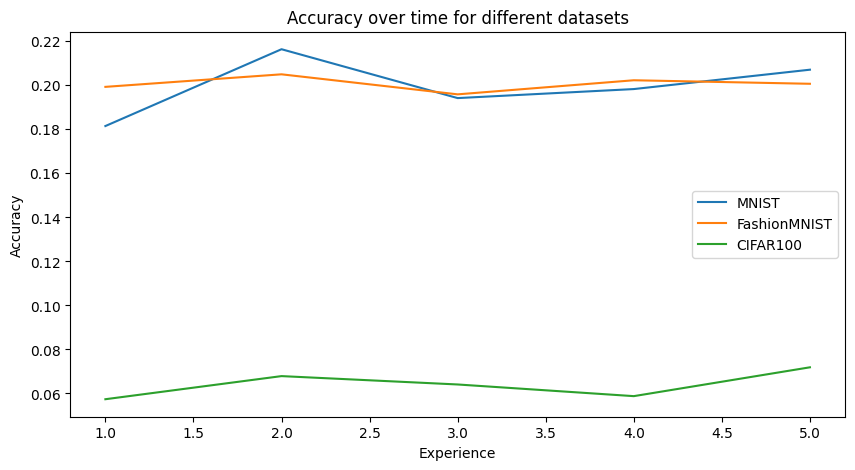

In [4]:
import torch
import torchvision
import matplotlib.pyplot as plt

from avalanche.benchmarks.classic import SplitMNIST, SplitCIFAR100
from avalanche.benchmarks.utils import as_classification_dataset
from avalanche.evaluation.metrics import accuracy_metrics
from avalanche.logging import InteractiveLogger, TextLogger
from avalanche.training.plugins import EvaluationPlugin
from avalanche.training.supervised import Naive

# Define model, loss function, and optimizer
def get_model(output_size):
    return torch.nn.Sequential(
        torch.nn.Flatten(),
        torch.nn.Linear(28 * 28, 512),
        torch.nn.ReLU(),
        torch.nn.Linear(512, output_size)
    )

model_mnist = get_model(10)
model_fashion_mnist = get_model(10)

model_cifar100 = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(3 * 32 * 32, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 100)
)

criterion = torch.nn.CrossEntropyLoss()
optimizer_mnist = torch.optim.SGD(model_mnist.parameters(), lr=0.01)
optimizer_fashion_mnist = torch.optim.SGD(model_fashion_mnist.parameters(), lr=0.01)
optimizer_cifar100 = torch.optim.SGD(model_cifar100.parameters(), lr=0.01)

# Evaluation plugin
interactive_logger = InteractiveLogger()
text_logger = TextLogger(open('log.txt', 'w'))
eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    loggers=[interactive_logger, text_logger]
)

# Load the datasets using Avalanche
scenario_mnist = SplitMNIST(n_experiences=5, seed=1)
scenario_cifar100 = SplitCIFAR100(n_experiences=5, seed=1)

# Load FashionMNIST using torchvision and create a custom benchmark
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))
])

fashion_mnist_train = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True)
fashion_mnist_test = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True)

# Creating classification datasets
train_fashion_mnist = as_classification_dataset(fashion_mnist_train, transform_groups={'train': transform, 'eval': transform})
test_fashion_mnist = as_classification_dataset(fashion_mnist_test, transform_groups={'train': transform, 'eval': transform})

from avalanche.benchmarks import nc_benchmark

scenario_fashion_mnist = nc_benchmark(
    train_dataset=train_fashion_mnist,
    test_dataset=test_fashion_mnist,
    n_experiences=5,
    task_labels=False,
    shuffle=True,
    seed=1
)

# Naive strategies for each dataset
naive_mnist = Naive(model_mnist, optimizer_mnist, criterion, train_mb_size=32, train_epochs=2, eval_mb_size=32, evaluator=eval_plugin)
naive_fashion_mnist = Naive(model_fashion_mnist, optimizer_fashion_mnist, criterion, train_mb_size=32, train_epochs=2, eval_mb_size=32, evaluator=eval_plugin)
naive_cifar100 = Naive(model_cifar100, optimizer_cifar100, criterion, train_mb_size=32, train_epochs=2, eval_mb_size=32, evaluator=eval_plugin)

# Function to run the strategy on a given scenario
def run_naive_strategy(scenario, strategy):
    accuracies = []
    for experience in scenario.train_stream:
        strategy.train(experience)
        eval_results = strategy.eval(scenario.test_stream)
        acc = eval_results['Top1_Acc_Stream/eval_phase/test_stream/Task000']
        accuracies.append(acc)
    return accuracies

# Run strategies and collect results
results = {
    'MNIST': run_naive_strategy(scenario_mnist, naive_mnist),
    'FashionMNIST': run_naive_strategy(scenario_fashion_mnist, naive_fashion_mnist),
    'CIFAR100': run_naive_strategy(scenario_cifar100, naive_cifar100)
}

# Plotting results
plt.figure(figsize=(10, 5))
for dataset_name, accuracies in results.items():
    plt.plot(range(1, len(accuracies) + 1), accuracies, label=dataset_name)
plt.xlabel('Experience')
plt.ylabel('Accuracy')
plt.title('Accuracy over time for different datasets')
plt.legend()
plt.show()


Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/avalanche/training/templates/base.py:468: PositionalArgumentsDeprecatedWarning: Avalanche is transitioning to strategy constructors that accept named (keyword) arguments only. This is done to ensure that there is no confusion regarding the meaning of each argument (strategies can have many arguments). Your are passing 3 positional arguments to the Replay.__init__ method. Consider passing them as names arguments. The ability to pass positional arguments will be removed in the future.
  warnings.warn(error_str, category=PositionalArgumentsDeprecatedWarning)


-- >> Start of training phase << --
100%|██████████| 355/355 [00:06<00:00, 51.43it/s]
Epoch 0 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9635
	Top1_Acc_MB/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 355/355 [00:06<00:00, 51.64it/s]
Epoch 1 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9800
	Top1_Acc_MB/train_phase/train_stream/Task000 = 1.0000
-- >> End of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 58/58 [00:01<00:00, 46.80it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.9822
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 68/68 [00:00<00:00, 68.12it/s]
> Eval on experience 1 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.0000
-- Starting eval on experience 2 (Task 0) from test stream --
100%|██████████| 62/62 [00

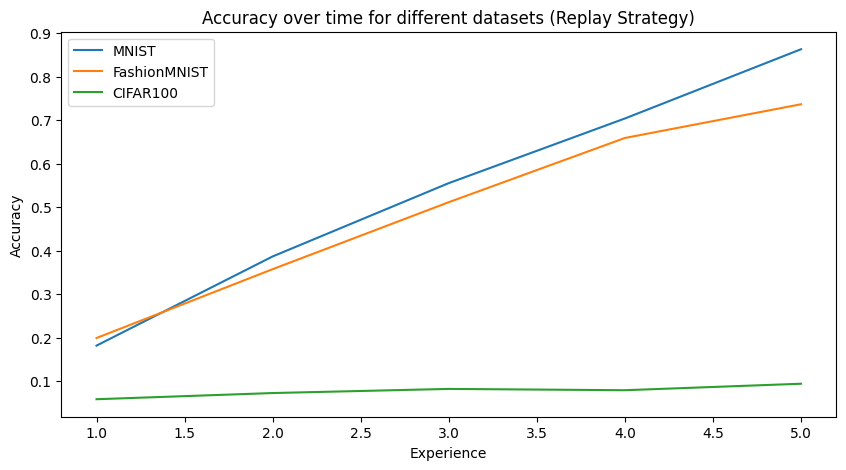

In [5]:
import torch
import torchvision
import matplotlib.pyplot as plt

from avalanche.benchmarks.classic import SplitMNIST, SplitCIFAR100
from avalanche.benchmarks.utils import as_classification_dataset
from avalanche.evaluation.metrics import accuracy_metrics
from avalanche.logging import InteractiveLogger, TextLogger
from avalanche.training.plugins import EvaluationPlugin
from avalanche.training.supervised import Replay

# Define model, loss function, and optimizer
def get_model(output_size):
    return torch.nn.Sequential(
        torch.nn.Flatten(),
        torch.nn.Linear(28 * 28, 512),
        torch.nn.ReLU(),
        torch.nn.Linear(512, output_size)
    )

model_mnist = get_model(10)
model_fashion_mnist = get_model(10)

model_cifar100 = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(3 * 32 * 32, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 100)
)

criterion = torch.nn.CrossEntropyLoss()
optimizer_mnist = torch.optim.SGD(model_mnist.parameters(), lr=0.01)
optimizer_fashion_mnist = torch.optim.SGD(model_fashion_mnist.parameters(), lr=0.01)
optimizer_cifar100 = torch.optim.SGD(model_cifar100.parameters(), lr=0.01)

# Evaluation plugin
interactive_logger = InteractiveLogger()
text_logger = TextLogger(open('log.txt', 'w'))
eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    loggers=[interactive_logger, text_logger]
)

# Load the datasets using Avalanche
scenario_mnist = SplitMNIST(n_experiences=5, seed=1)
scenario_cifar100 = SplitCIFAR100(n_experiences=5, seed=1)

# Load FashionMNIST using torchvision and create a custom benchmark
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))
])

fashion_mnist_train = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True)
fashion_mnist_test = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True)

# Creating classification datasets
train_fashion_mnist = as_classification_dataset(fashion_mnist_train, transform_groups={'train': transform, 'eval': transform})
test_fashion_mnist = as_classification_dataset(fashion_mnist_test, transform_groups={'train': transform, 'eval': transform})

from avalanche.benchmarks import nc_benchmark

scenario_fashion_mnist = nc_benchmark(
    train_dataset=train_fashion_mnist,
    test_dataset=test_fashion_mnist,
    n_experiences=5,
    task_labels=False,
    shuffle=True,
    seed=1
)

# Replay strategies for each dataset
replay_mnist = Replay(model_mnist, optimizer_mnist, criterion, mem_size=200, train_mb_size=32, train_epochs=2, eval_mb_size=32, evaluator=eval_plugin)
replay_fashion_mnist = Replay(model_fashion_mnist, optimizer_fashion_mnist, criterion, mem_size=200, train_mb_size=32, train_epochs=2, eval_mb_size=32, evaluator=eval_plugin)
replay_cifar100 = Replay(model_cifar100, optimizer_cifar100, criterion, mem_size=200, train_mb_size=32, train_epochs=2, eval_mb_size=32, evaluator=eval_plugin)

# Function to run the strategy on a given scenario
def run_replay_strategy(scenario, strategy):
    accuracies = []
    for experience in scenario.train_stream:
        strategy.train(experience)
        eval_results = strategy.eval(scenario.test_stream)
        acc = eval_results['Top1_Acc_Stream/eval_phase/test_stream/Task000']
        accuracies.append(acc)
    return accuracies

# Run strategies and collect results
results = {
    'MNIST': run_replay_strategy(scenario_mnist, replay_mnist),
    'FashionMNIST': run_replay_strategy(scenario_fashion_mnist, replay_fashion_mnist),
    'CIFAR100': run_replay_strategy(scenario_cifar100, replay_cifar100)
}

# Plotting results
plt.figure(figsize=(10, 5))
for dataset_name, accuracies in results.items():
    plt.plot(range(1, len(accuracies) + 1), accuracies, label=dataset_name)
plt.xlabel('Experience')
plt.ylabel('Accuracy')
plt.title('Accuracy over time for different datasets (Replay Strategy)')
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/avalanche/training/templates/base.py:468: PositionalArgumentsDeprecatedWarning: Avalanche is transitioning to strategy constructors that accept named (keyword) arguments only. This is done to ensure that there is no confusion regarding the meaning of each argument (strategies can have many arguments). Your are passing 3 positional arguments to the GDumb.__init__ method. Consider passing them as names arguments. The ability to pass positional arguments will be removed in the future.
  warnings.warn(error_str, category=PositionalArgumentsDeprecatedWarning)


-- >> Start of training phase << --
100%|██████████| 7/7 [00:00<00:00, 64.61it/s]
Epoch 0 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8800
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.8750
100%|██████████| 7/7 [00:00<00:00, 70.06it/s]
Epoch 1 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9400
	Top1_Acc_MB/train_phase/train_stream/Task000 = 1.0000
-- >> End of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 58/58 [00:00<00:00, 62.75it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.9541
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 68/68 [00:00<00:00, 69.01it/s]
> Eval on experience 1 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.8856
-- Starting eval on experience 2 (Task 0) from test stream --
100%|██████████| 62/62 [00:00<00:0

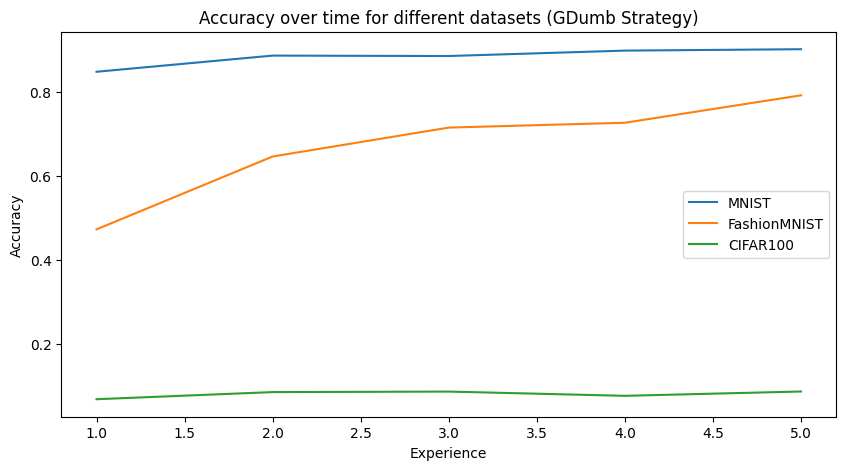

In [7]:
# Assuming data and models are already loaded and defined as in the previous sections

from avalanche.training.supervised import GDumb

# Define the GDumb strategy for each dataset
gdumb_mnist = GDumb(
    model_mnist, optimizer_mnist, criterion,
    mem_size=200, train_mb_size=32, train_epochs=2, eval_mb_size=32, evaluator=eval_plugin
)

gdumb_fashion_mnist = GDumb(
    model_fashion_mnist, optimizer_fashion_mnist, criterion,
    mem_size=200, train_mb_size=32, train_epochs=2, eval_mb_size=32, evaluator=eval_plugin
)

gdumb_cifar100 = GDumb(
    model_cifar100, optimizer_cifar100, criterion,
    mem_size=200, train_mb_size=32, train_epochs=2, eval_mb_size=32, evaluator=eval_plugin
)

# Function to run the strategy on a given scenario
def run_gdumb_strategy(scenario, strategy):
    accuracies = []
    for experience in scenario.train_stream:
        strategy.train(experience)
        eval_results = strategy.eval(scenario.test_stream)
        acc = eval_results['Top1_Acc_Stream/eval_phase/test_stream/Task000']
        accuracies.append(acc)
    return accuracies

# Run the GDumb strategy and collect results
results_gdumb = {
    'MNIST': run_gdumb_strategy(scenario_mnist, gdumb_mnist),
    'FashionMNIST': run_gdumb_strategy(scenario_fashion_mnist, gdumb_fashion_mnist),
    'CIFAR100': run_gdumb_strategy(scenario_cifar100, gdumb_cifar100)
}

# Plotting results for GDumb strategy
plt.figure(figsize=(10, 5))
for dataset_name, accuracies in results_gdumb.items():
    plt.plot(range(1, len(accuracies) + 1), accuracies, label=dataset_name)
plt.xlabel('Experience')
plt.ylabel('Accuracy')
plt.title('Accuracy over time for different datasets (GDumb Strategy)')
plt.legend()
plt.show()